In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

Загрузка датасета.


In [3]:
df = pd.read_csv('Global YouTube Statistics.csv', encoding='ISO-8859-1')
df_num_cols = df.select_dtypes(include='number').drop(columns=['Latitude', 'Longitude'])
df_obj_cols = df.select_dtypes(exclude='number').drop(columns=['Abbreviation'])
df.head()

,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880



Описание датасета:  
- rank: Position of the YouTube channel based on the number of subscribers  
- Youtuber: Name of the YouTube channel  
- subscribers: Number of subscribers to the channel  
- video views: Total views across all videos on the channel  
- category: Category or niche of the channel  
- Title: Title of the YouTube channel  
- uploads: Total number of videos uploaded on the channel  
- Country: Country where the YouTube channel originates  
- Abbreviation: Abbreviation of the country  
- channel_type: Type of the YouTube channel (e.g., individual, brand)  
- video_views_rank: Ranking of the channel based on total video views  
- country_rank: Ranking of the channel based on the number of subscribers within its country  
- channel_type_rank: Ranking of the channel based on its type (individual or brand)  
- video_views_for_the_last_30_days: Total video views in the last 30 days  
- lowest_monthly_earnings: Lowest estimated monthly earnings from the channel  
- highest_monthly_earnings: Highest estimated monthly earnings from the channel  
- lowest_yearly_earnings: Lowest estimated yearly earnings from the channel  
- highest_yearly_earnings: Highest estimated yearly earnings from the channel  
- subscribers_for_last_30_days: Number of new subscribers gained in the last 30 days  
- created_year: Year when the YouTube channel was created  
- created_month: Month when the YouTube channel was created  
- created_date: Exact date of the YouTube channel's creation  
- Gross tertiary education enrollment (%): Percentage of the population enrolled in tertiary education in the country  
- Population: Total population of the country  
- Unemployment rate: Unemployment rate in the country  
- Urban_population: Percentage of the population living in urban areas  
- Latitude: Latitude coordinate of the country's location  
- Longitude: Longitude coordinate of the country's location  

> 1. EDA

In [6]:
df_num_cols.describe().style.format(precision=1)

,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,created_year,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population
count,995.0,995.0,995.0,995.0,994.0,879.0,962.0,939.0,995.0,995.0,995.0,995.0,658.0,990.0,990.0,872.0,872.0,872.0,872.0
mean,498.0,22982412.1,11039537052.0,9187.1,554248.9,386.1,745.7,175610284.8,36886.1,589807.8,442257.4,7081813.9,349079.1,2012.6,15.7,63.6,430387266.8,9.3,224214981.6
std,287.4,17526105.3,14110844376.8,34151.4,1362782.2,1232.2,1944.4,416378166.2,71858.7,1148622.5,861216.1,13797037.6,614355.4,4.5,8.8,26.1,472794722.5,4.9,154687362.7
min,1.0,12300000.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1970.0,1.0,7.6,202506.0,0.8,35588.0
25%,249.5,14500000.0,4288145410.0,194.5,323.0,11.0,27.0,20137500.0,2700.0,43500.0,32650.0,521750.0,100000.0,2009.0,8.0,36.3,83355411.0,5.3,55908316.0
50%,498.0,17700000.0,7760819588.0,729.0,915.5,51.0,65.5,64085000.0,13300.0,212700.0,159500.0,2600000.0,200000.0,2013.0,16.0,68.0,328239523.0,9.4,270663028.0
75%,746.5,24600000.0,13554701853.0,2667.5,3584.5,123.0,139.8,168826500.0,37900.0,606800.0,455100.0,7300000.0,400000.0,2016.0,23.0,88.2,328239523.0,14.7,270663028.0
max,995.0,245000000.0,228000000000.0,301308.0,4057944.0,7741.0,7741.0,6589000000.0,850900.0,13600000.0,10200000.0,163400000.0,8000000.0,2022.0,31.0,113.1,1397715000.0,14.7,842933962.0


Выявление аномалий и выбросов.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   rank                                     995 non-null    int64  
 1   Youtuber                                 995 non-null    object 
 2   subscribers                              995 non-null    int64  
 3   video views                              995 non-null    float64
 4   category                                 949 non-null    object 
 5   Title                                    995 non-null    object 
 6   uploads                                  995 non-null    int64  
 7   Country                                  873 non-null    object 
 8   Abbreviation                             873 non-null    object 
 9   channel_type                             965 non-null    object 
 10  video_views_rank                         994 non-n

Визуальный поиск пропущенных значений.

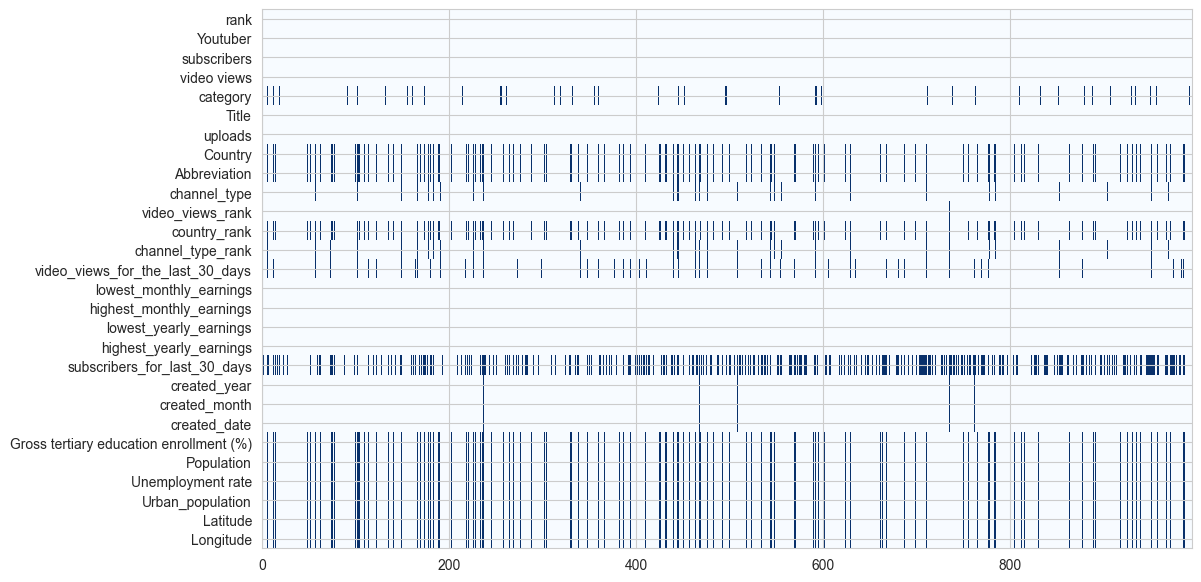

In [8]:
plt.figure(figsize=(12, 7))
plt.imshow(df.isna().T, cmap="Blues", interpolation='nearest', aspect='auto')
plt.yticks(np.arange(len(df.columns)), labels=df.columns.to_list())
plt.show()

Поиск выбросов.

In [9]:
def find_outliers(data):
    iqr = data.quantile(0.75) - data.quantile(0.25)
    lower_bound = data.quantile(0.25) - (iqr * 1.5)
    upper_bound = data.quantile(0.75) + (iqr * 1.5)
    return data[(data < lower_bound) | (data > upper_bound)]

In [10]:
df_num_cols_reduced = df_num_cols.drop(columns=[
    'Urban_population', 'created_date', 'created_year',
    'subscribers_for_last_30_days', 'highest_monthly_earnings', 'lowest_monthly_earnings'
])  # subscribers_for_last_30_days dropped due to many Nan's
df_num_cols_reduced.describe().style.format(precision=1)

,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_yearly_earnings,highest_yearly_earnings,Gross tertiary education enrollment (%),Population,Unemployment rate
count,995.0,995.0,995.0,995.0,994.0,879.0,962.0,939.0,995.0,995.0,872.0,872.0,872.0
mean,498.0,22982412.1,11039537052.0,9187.1,554248.9,386.1,745.7,175610284.8,442257.4,7081813.9,63.6,430387266.8,9.3
std,287.4,17526105.3,14110844376.8,34151.4,1362782.2,1232.2,1944.4,416378166.2,861216.1,13797037.6,26.1,472794722.5,4.9
min,1.0,12300000.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,7.6,202506.0,0.8
25%,249.5,14500000.0,4288145410.0,194.5,323.0,11.0,27.0,20137500.0,32650.0,521750.0,36.3,83355411.0,5.3
50%,498.0,17700000.0,7760819588.0,729.0,915.5,51.0,65.5,64085000.0,159500.0,2600000.0,68.0,328239523.0,9.4
75%,746.5,24600000.0,13554701853.0,2667.5,3584.5,123.0,139.8,168826500.0,455100.0,7300000.0,88.2,328239523.0,14.7
max,995.0,245000000.0,228000000000.0,301308.0,4057944.0,7741.0,7741.0,6589000000.0,10200000.0,163400000.0,113.1,1397715000.0,14.7


Попробуем удалить запредельные значения.

In [11]:
df_num_cols_reduced = df_num_cols_reduced[df_num_cols_reduced['video views'] >= 1]
indx = list()
for x in df_num_cols_reduced.columns:
    res = find_outliers(df_num_cols_reduced[x])
    indx.append(res.index.to_list())
df_num_cols_reduced.drop(index=indx[1], inplace=True)
print(len(indx))
df_num_cols_reduced.describe().style.format(precision=1)

13


,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_yearly_earnings,highest_yearly_earnings,Gross tertiary education enrollment (%),Population,Unemployment rate
count,909.0,909.0,909.0,909.0,908.0,808.0,882.0,860.0,909.0,909.0,801.0,801.0,801.0
mean,540.0,19132123.2,8897915660.0,8538.8,513999.5,380.1,723.0,156036529.8,384346.1,6153715.9,64.0,421877221.8,9.3
std,263.5,6374180.6,6652945830.9,32865.0,1316416.0,1202.7,1909.3,402214458.1,753006.8,12064705.2,25.9,465724276.9,4.9
min,83.0,12300000.0,2634.0,0.0,14.0,1.0,1.0,1.0,0.0,0.0,7.6,202506.0,0.8
25%,312.0,14400000.0,4120324310.0,206.0,378.8,14.0,33.0,18540500.0,33000.0,528200.0,36.3,83132799.0,5.3
50%,540.0,16900000.0,7274150246.0,733.0,1002.0,63.0,73.5,59032000.0,149000.0,2400000.0,68.0,328239523.0,9.7
75%,768.0,22500000.0,11827310821.0,2452.0,3603.8,125.0,141.8,149607000.0,409200.0,6500000.0,88.2,328239523.0,14.7
max,995.0,39000000.0,56106087508.0,301308.0,4057944.0,7741.0,7741.0,6589000000.0,10200000.0,163400000.0,113.1,1397715000.0,14.7


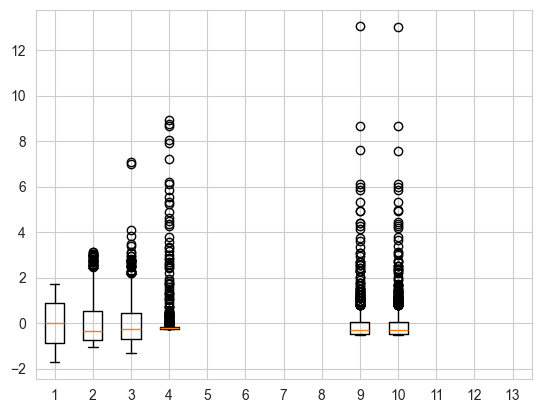

In [12]:
scaler = MinMaxScaler()
df_num_cols_reduced_norm = scaler.fit_transform(df_num_cols_reduced)
scaler = StandardScaler()
df_num_cols_reduced_norm = pd.DataFrame(scaler.fit_transform(df_num_cols_reduced_norm))
plt.boxplot(df_num_cols_reduced_norm)
plt.show()

Идентификация связей и корреляций между переменными


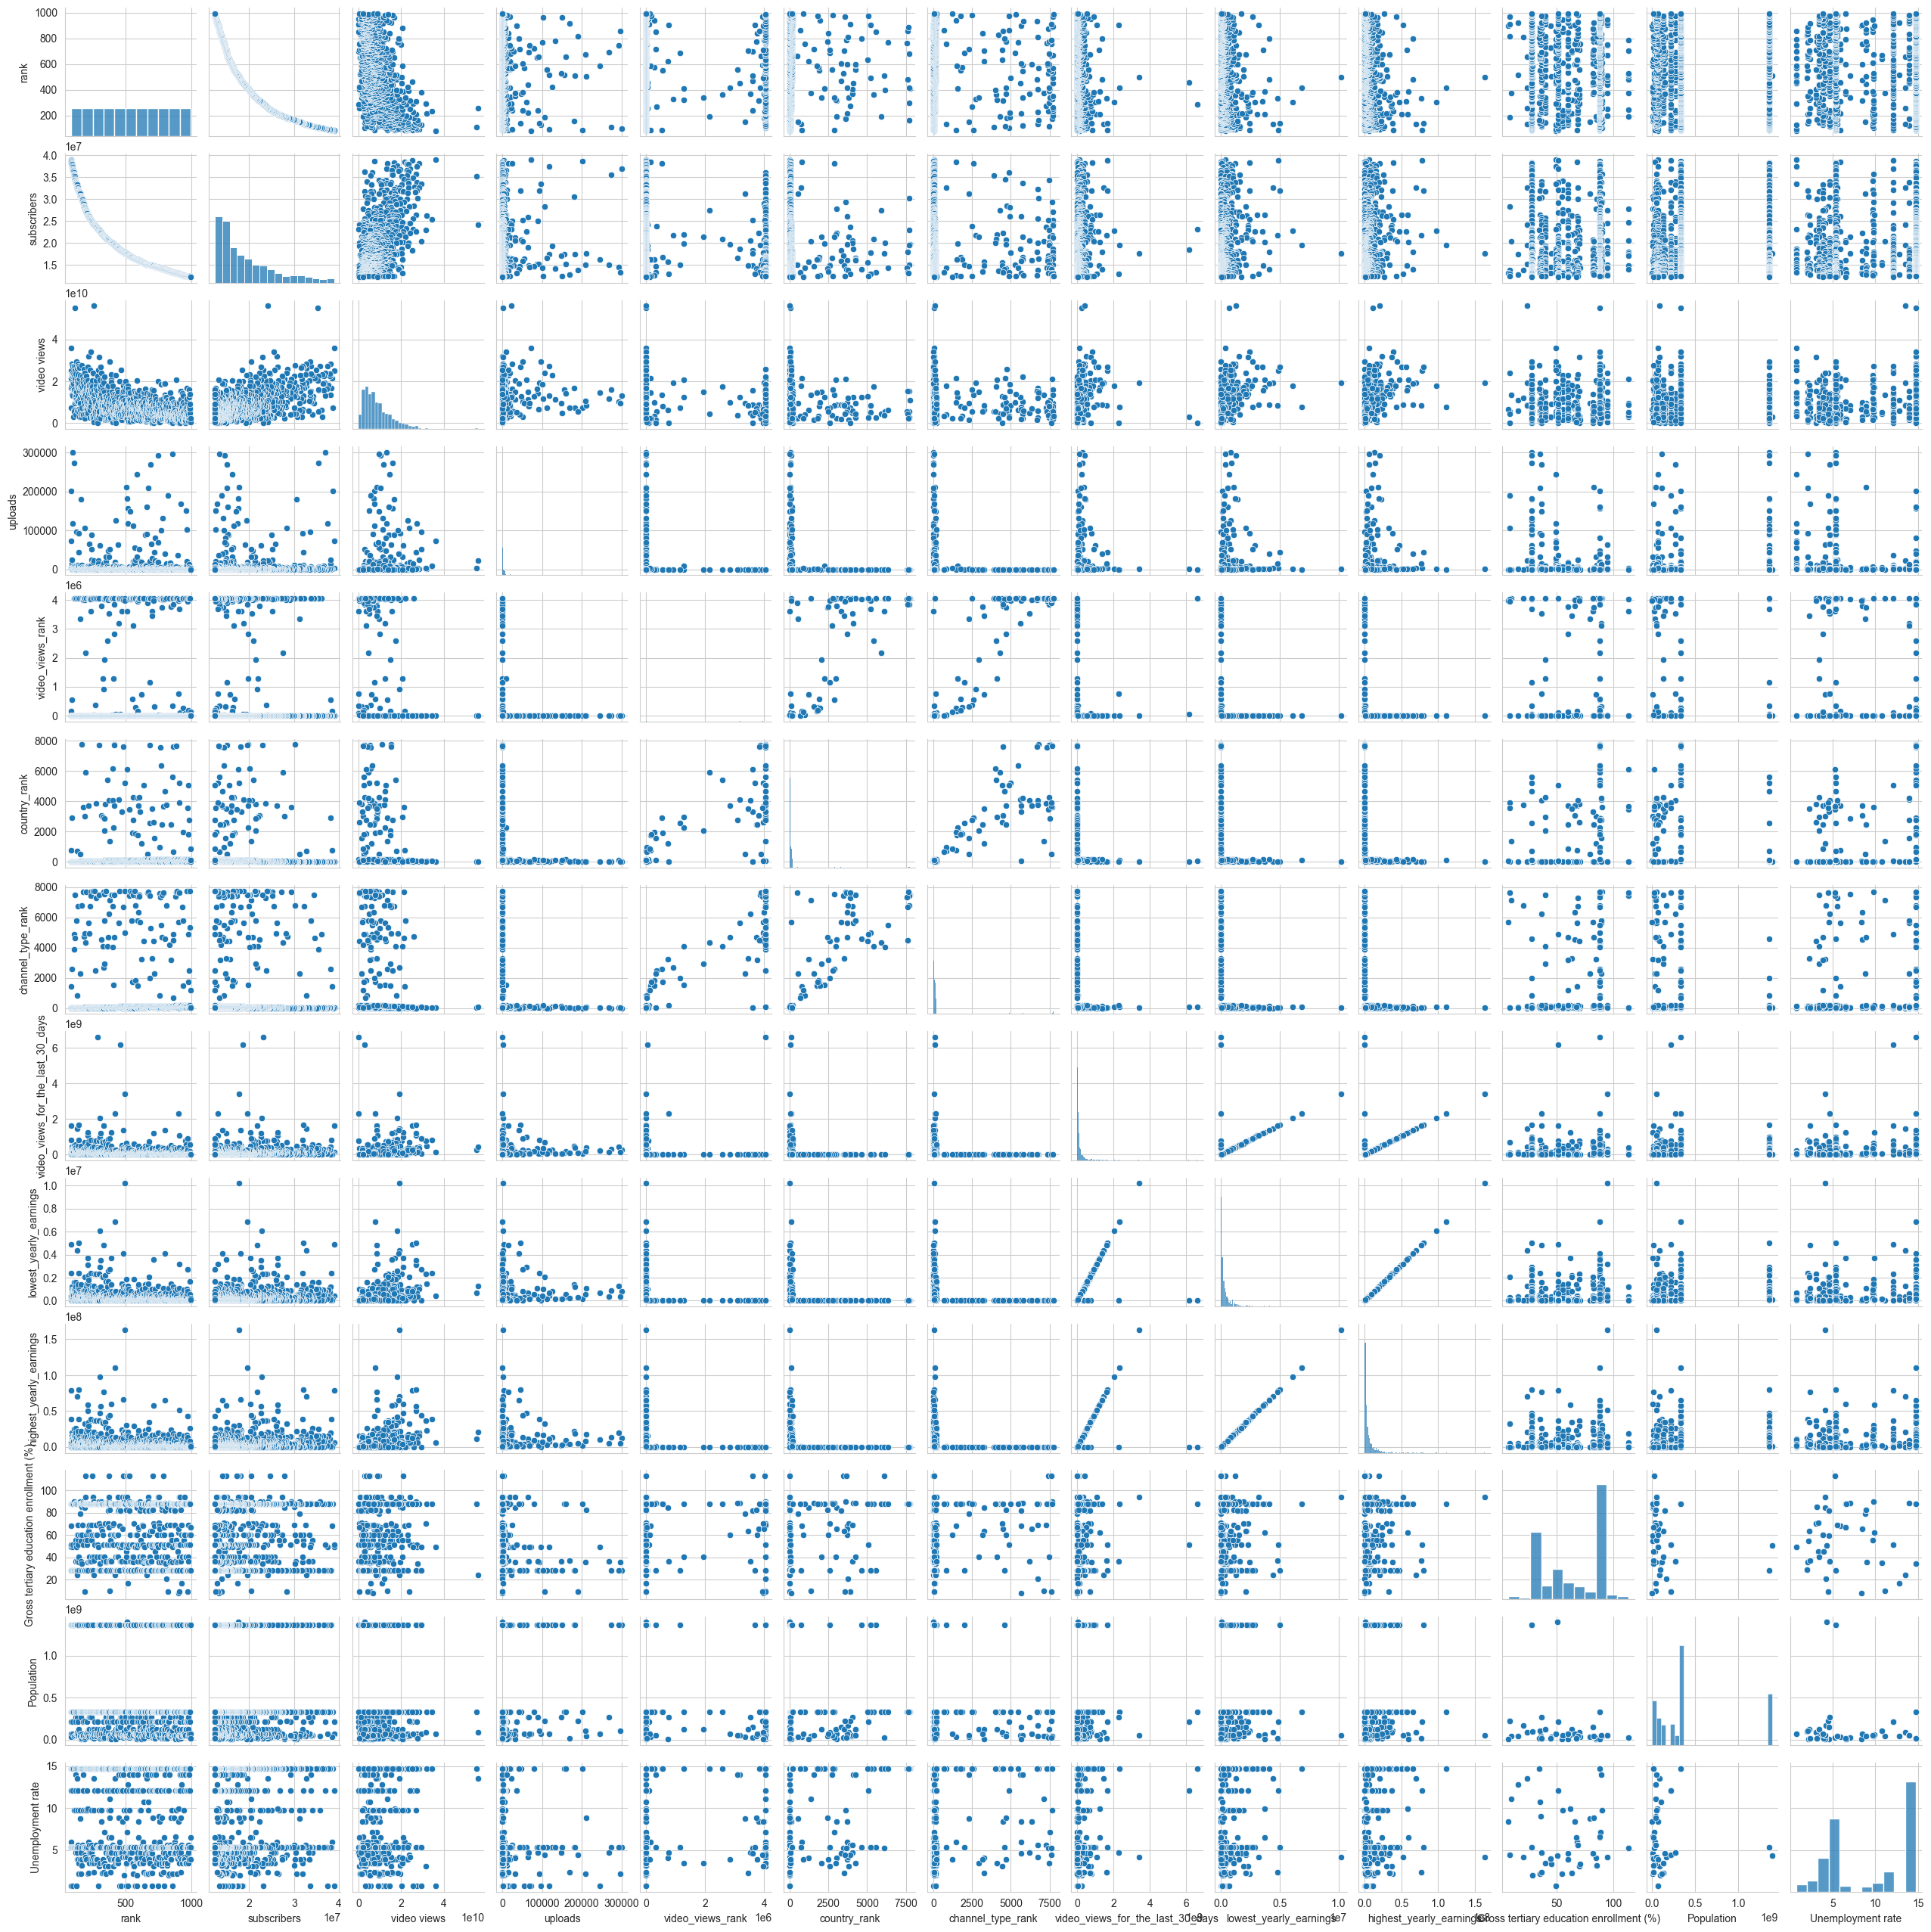

In [13]:
sns.pairplot(df_num_cols_reduced, dropna=True, height=2)
plt.show()

Кореляции между признаками



In [469]:
df_corr = df_num_cols_reduced.corr(method='spearman')
df_corr.describe()

,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_yearly_earnings,highest_yearly_earnings,Gross tertiary education enrollment (%),Population,Unemployment rate
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,-0.030040,0.030502,0.144739,0.068582,-0.148540,0.132201,0.001005,0.187807,0.184797,0.184732,0.091980,0.145833,0.180501
std,0.476154,0.476644,0.463970,0.412182,0.556490,0.422331,0.425929,0.542304,0.562893,0.562789,0.348548,0.327156,0.338230
min,-0.999947,-0.999947,-0.742778,-0.498215,-0.760086,-0.294622,-0.422557,-0.720390,-0.760086,-0.759934,-0.261121,-0.261121,-0.149598
25%,-0.215688,-0.291286,-0.103670,-0.200869,-0.720390,-0.288009,-0.354720,-0.241792,-0.215688,-0.215452,-0.089006,-0.027800,-0.008009
50%,-0.056276,0.056148,0.099828,0.029723,-0.080525,0.210905,-0.103670,0.120881,0.120668,0.120398,-0.036479,0.062259,0.038200
75%,0.291454,0.217125,0.479301,0.337297,0.337714,0.337714,0.334891,0.514807,0.478484,0.479301,0.074945,0.120881,0.323133
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


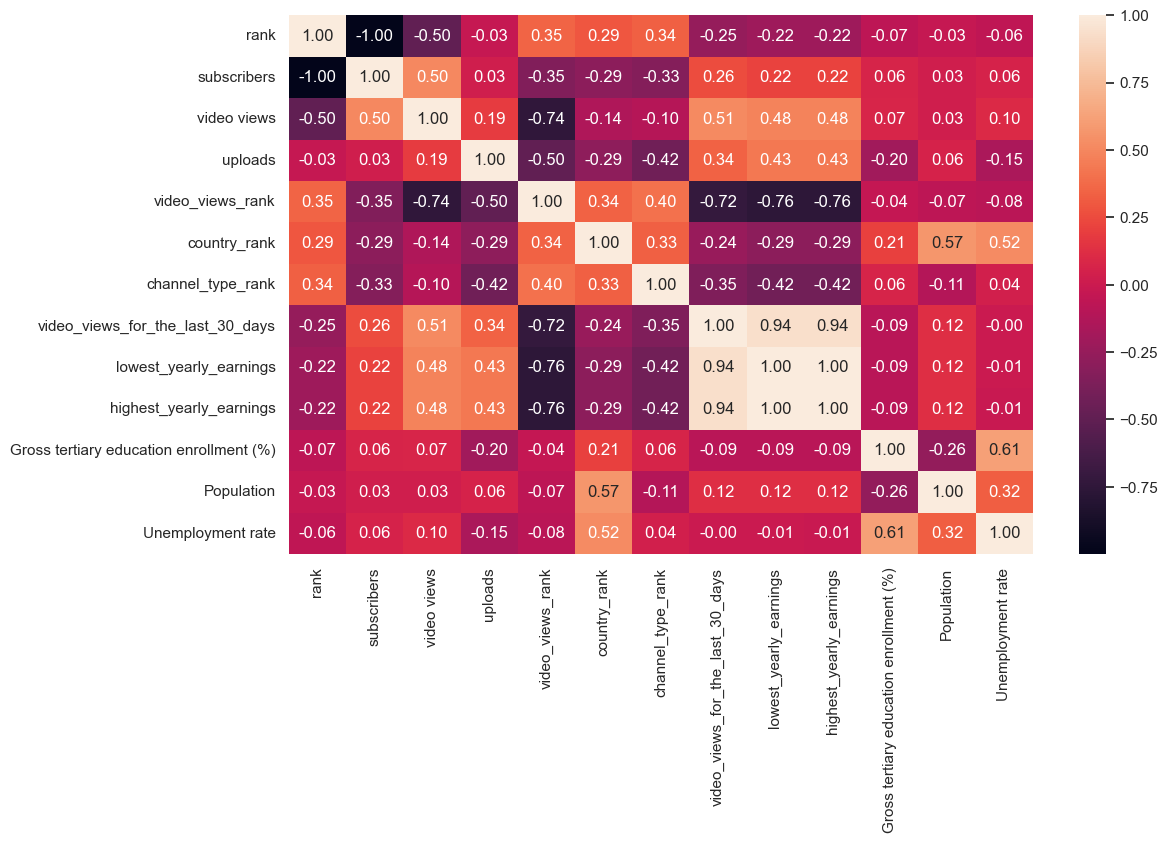

In [470]:
plt.figure(figsize=(12, 7))
sns.heatmap(df_corr, annot=True, fmt='.2f')
plt.show()

Построение дендрограммы

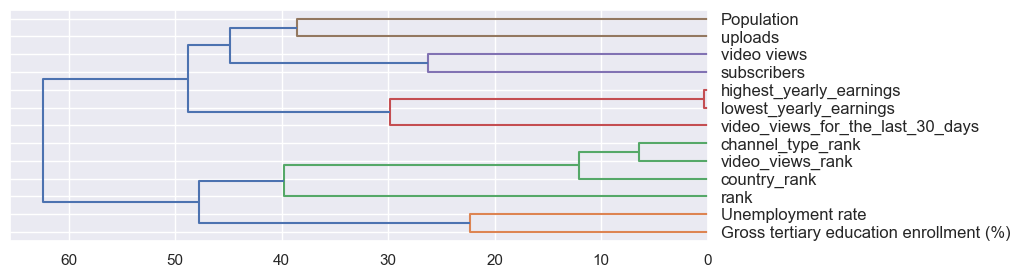

In [471]:
df_num_cols_reduced2 = pd.DataFrame(df_num_cols_reduced_norm).dropna(how='any')

clusters = hierarchy.linkage(
    df_num_cols_reduced2.T,
    method='ward',
)
plt.figure(figsize=(9, 3))
dn = hierarchy.dendrogram(clusters,
                          orientation='left',
                          labels=df_num_cols_reduced.T.index)


#### 1. Зависимость просмотров от подписчиков  
> Положительная кореляция

<Figure size 1000x500 with 0 Axes>

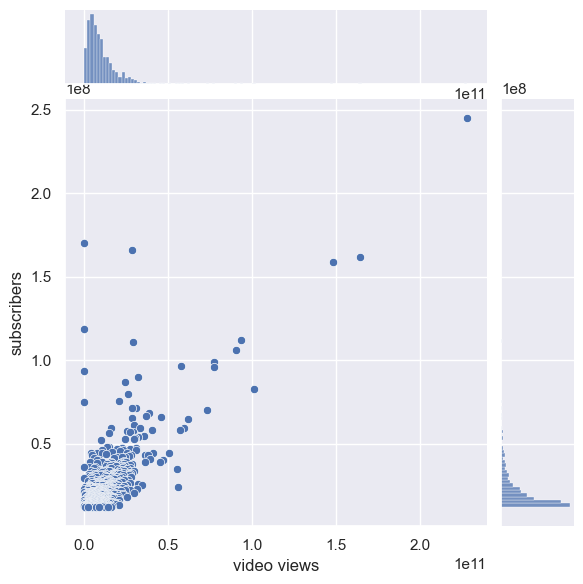

In [472]:
plt.figure(figsize=(10, 5))
sns.jointplot(x=df['video views'], y=df['subscribers'])
plt.show()

#### 2. Распределение каналов по странам

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
Country,United States,India,Brazil,United Kingdom,Mexico,Indonesia,Spain,Thailand,South Korea,Russia,...,Malaysia,Latvia,Andorra,Finland,El Salvador,Cuba,China,Barbados,Bangladesh,Kuwait
Youtuber,313,168,62,43,33,28,22,18,17,16,...,1,1,1,1,1,1,1,1,1,1


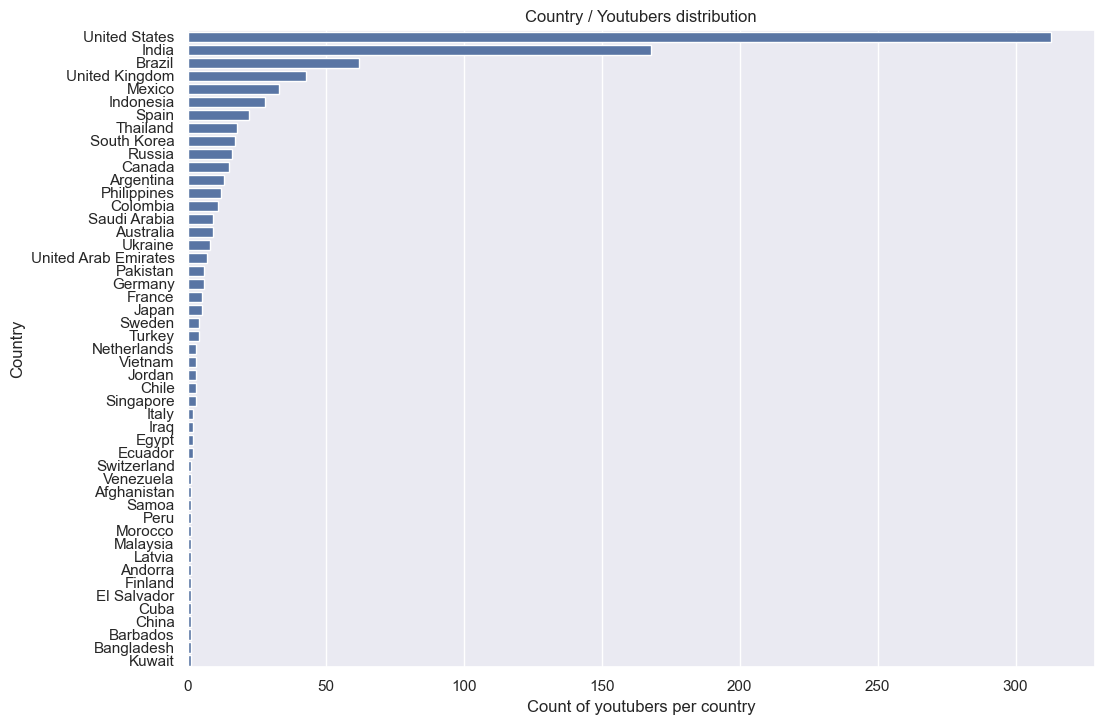

In [473]:
c_yt = df[['Country', 'Youtuber']].groupby('Country').count().sort_values(
    'Youtuber', ascending=False).reset_index()
display(c_yt.T)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.barplot(c_yt, y='Country',
            x='Youtuber').set(xlabel="Count of youtubers per country",
                              ylabel="Country",
                              title='Country / Youtubers distribution')
plt.show()


#### 3. Чем больше загрузок тем больше заработок?  
> Слабая Кореляция 0.46

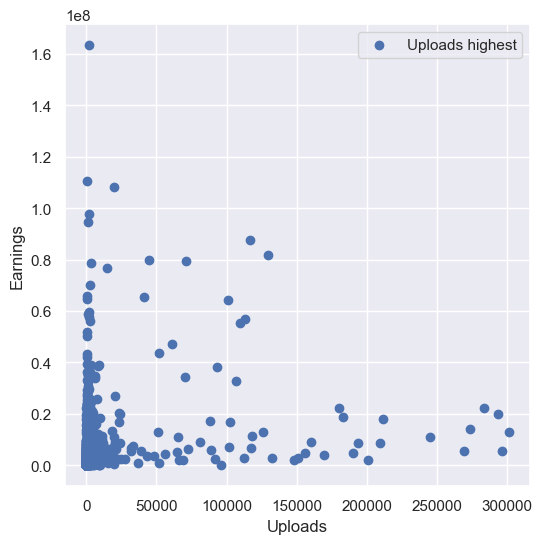

In [502]:
u_hle = df[['uploads', 'highest_yearly_earnings']]

plt.figure(figsize=(6, 6))
plt.scatter(x=u_hle['uploads'], y=u_hle['highest_yearly_earnings'], label='Uploads highest')
plt.xlabel('Uploads')
plt.ylabel('Earnings')
plt.legend()
plt.show()

#### 4. Подписчиков больше ранк выше?  
> Кореляция 1.0 🤷‍♂️

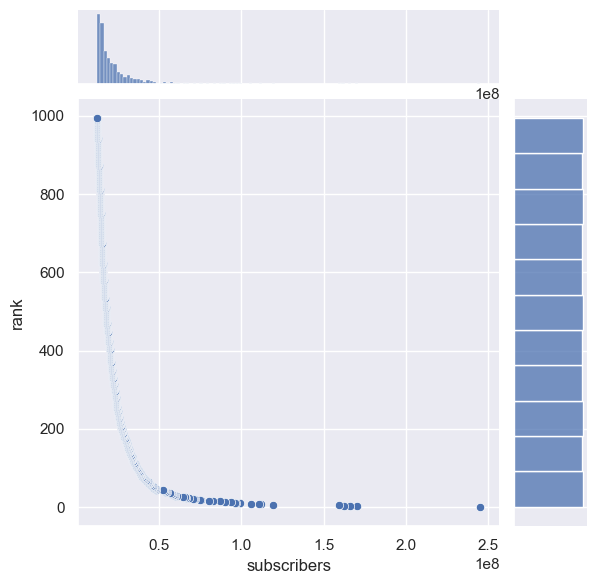

In [505]:
# plt.figure(figsize=(12, 5))
sns.jointplot(x=df['subscribers'], y=df['rank'])
plt.show()

> 2. Корреляционный анализ

In [506]:
df_exp = df[['subscribers', 'video views']]
df_exp = df_exp[df_exp['video views'] > 0]
df_exp.head().style.format(precision=1)

,subscribers,video views
0,245000000,228000000000.0
2,166000000,28368841870.0
3,162000000,164000000000.0
4,159000000,148000000000.0
6,112000000,93247040539.0


In [477]:
df_exp.corr(method='pearson')

,subscribers,video views
subscribers,1.000000,0.824262
video views,0.824262,1.000000


In [478]:
x_val = pd.DataFrame(df_exp['video views'])
y_val = pd.DataFrame(df_exp['subscribers'])

x_train, x_test, y_train, y_test = train_test_split(x_val,
                                                    y_val,
                                                    test_size=0.25,
                                                    random_state=42)

(x_train.shape, y_train.shape)

((740, 1), (740, 1))

In [479]:
lr = LinearRegression()

lr.fit(x_train, y_train)



LinearRegression()

In [480]:
y_pred = lr.predict(x_test)

result_df = pd.DataFrame({
    "y_test": y_test['subscribers'].values,
    "y_pred": y_pred.reshape(247).tolist()
})

result_df.head(10).style.format(precision=1)

,y_test,y_pred
0,22300000,20194056.6
1,31700000,27779676.8
2,17600000,13990313.5
3,13300000,14985667.2
4,37600000,29460479.6
5,19900000,25294659.3
6,12900000,14219193.7
7,34900000,36644206.2
8,43500000,38548449.0
9,16900000,21048864.6


In [508]:
print(f'R2: {metrics.r2_score(y_test, y_pred)}')
# print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred)}')
# print(f'MSE: {metrics.mean_squared_error(y_test, y_pred)}')
# print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
scores = cross_val_score(lr, x_val, y_val, scoring='r2', cv=10)
print(np.mean(scores))

R2: 0.6201023967227399
-205.23034509966092


e:\!Projects\!Netology\DS_PythonStatistic\Hw_Final_Other\env\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\!Projects\!Netology\DS_PythonStatistic\Hw_Final_Other\env\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\!Projects\!Netology\DS_PythonStatistic\Hw_Final_Other\env\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subse

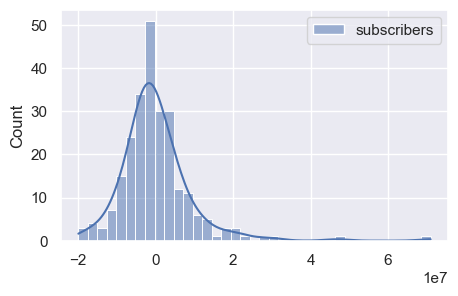

In [507]:
sns.set(rc={'figure.figsize': (5, 3)})
sns.histplot(
    (y_test - y_pred),
    kde=True,
)
plt.show()

* Как изменится точность, если опустить пункт 2 и не убирать из данных нулевые просмотры?  
Ухудшится